In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bin import utils

In [3]:
gdata = sc.read_h5ad('./RNA/spatial.filtered.guide.bin100.h5')
fdata = sc.read_h5ad('./RNA/spatial.combined.clustered.h5')

In [7]:
fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100
fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]
gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]

common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
fdata = fdata[common_bins].copy()
gdata = gdata[common_bins].copy()

In [9]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240702-Exclusive/bin/utils.py:78: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [11]:
scdata = sc.read_h5ad('./RNA/sc.combined.dedup.clustered.h5')

# Phenotype <-> Distribution

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


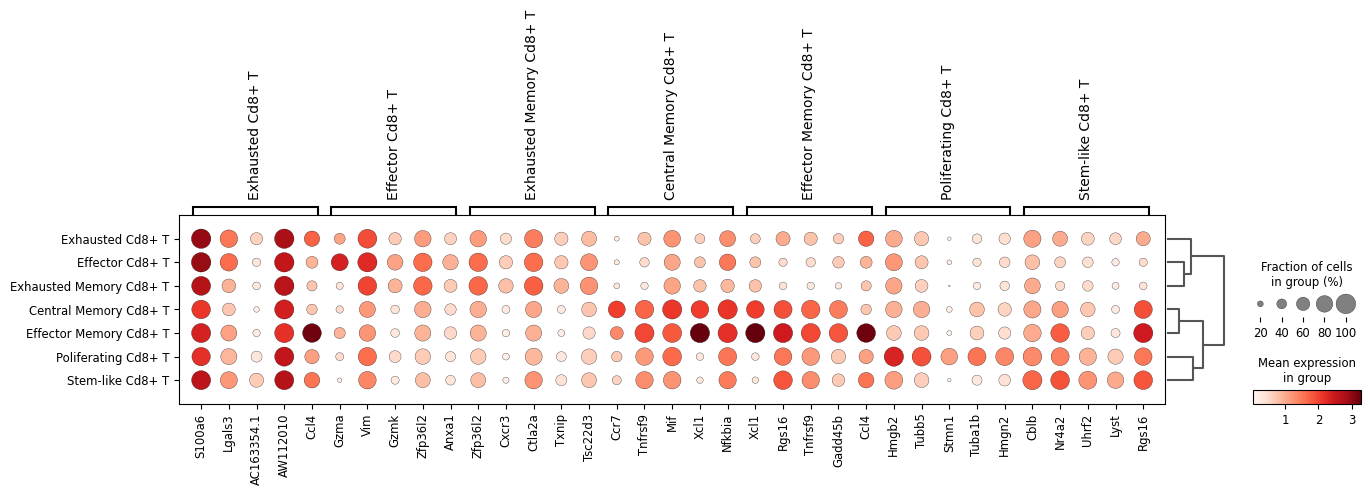

In [21]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

sc.tl.rank_genes_groups(scdata, groupby='leiden', method='t-test')
ax = sc.pl.rank_genes_groups_dotplot(scdata, n_genes=5, return_fig=True)
ax.show()

In [29]:
pval_cutoff = 0.01
top_n = 10

result = scdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df

Gene  Log2FoldChange           padj      score                Cluster
0      Ccr7        3.479914  2.546920e-173  35.267666  Central Memory Cd8+ T
1   Tnfrsf9        1.685727  5.953150e-144  29.849846  Central Memory Cd8+ T
2       Mif        1.475150  1.459173e-141  29.723330  Central Memory Cd8+ T
3      Xcl1        2.405703  1.666246e-116  26.420259  Central Memory Cd8+ T
4    Nfkbia        1.209895  2.475211e-116  25.618769  Central Memory Cd8+ T
..      ...             ...            ...        ...                    ...
65  Ubash3b        1.844823  1.287146e-101  23.862261       Stem-like Cd8+ T
66    Stat3        1.234383  1.520594e-103  23.814705       Stem-like Cd8+ T
67   Filip1        1.958710   2.546966e-98  23.397350       Stem-like Cd8+ T
68     Lag3        1.285982  3.198715e-100  23.342068       Stem-like Cd8+ T
69  Tmem163        1.478730   1.503199e-91  22.297554       Stem-like Cd8+ T

[70 rows x 5 columns]

In [30]:
for t_type in top_genes_df.Cluster.unique():
    sc.tl.score_genes(fdata,
        gene_list=top_genes_df[top_genes_df.Cluster == t_type].Gene,
        score_name=t_type + '_score')

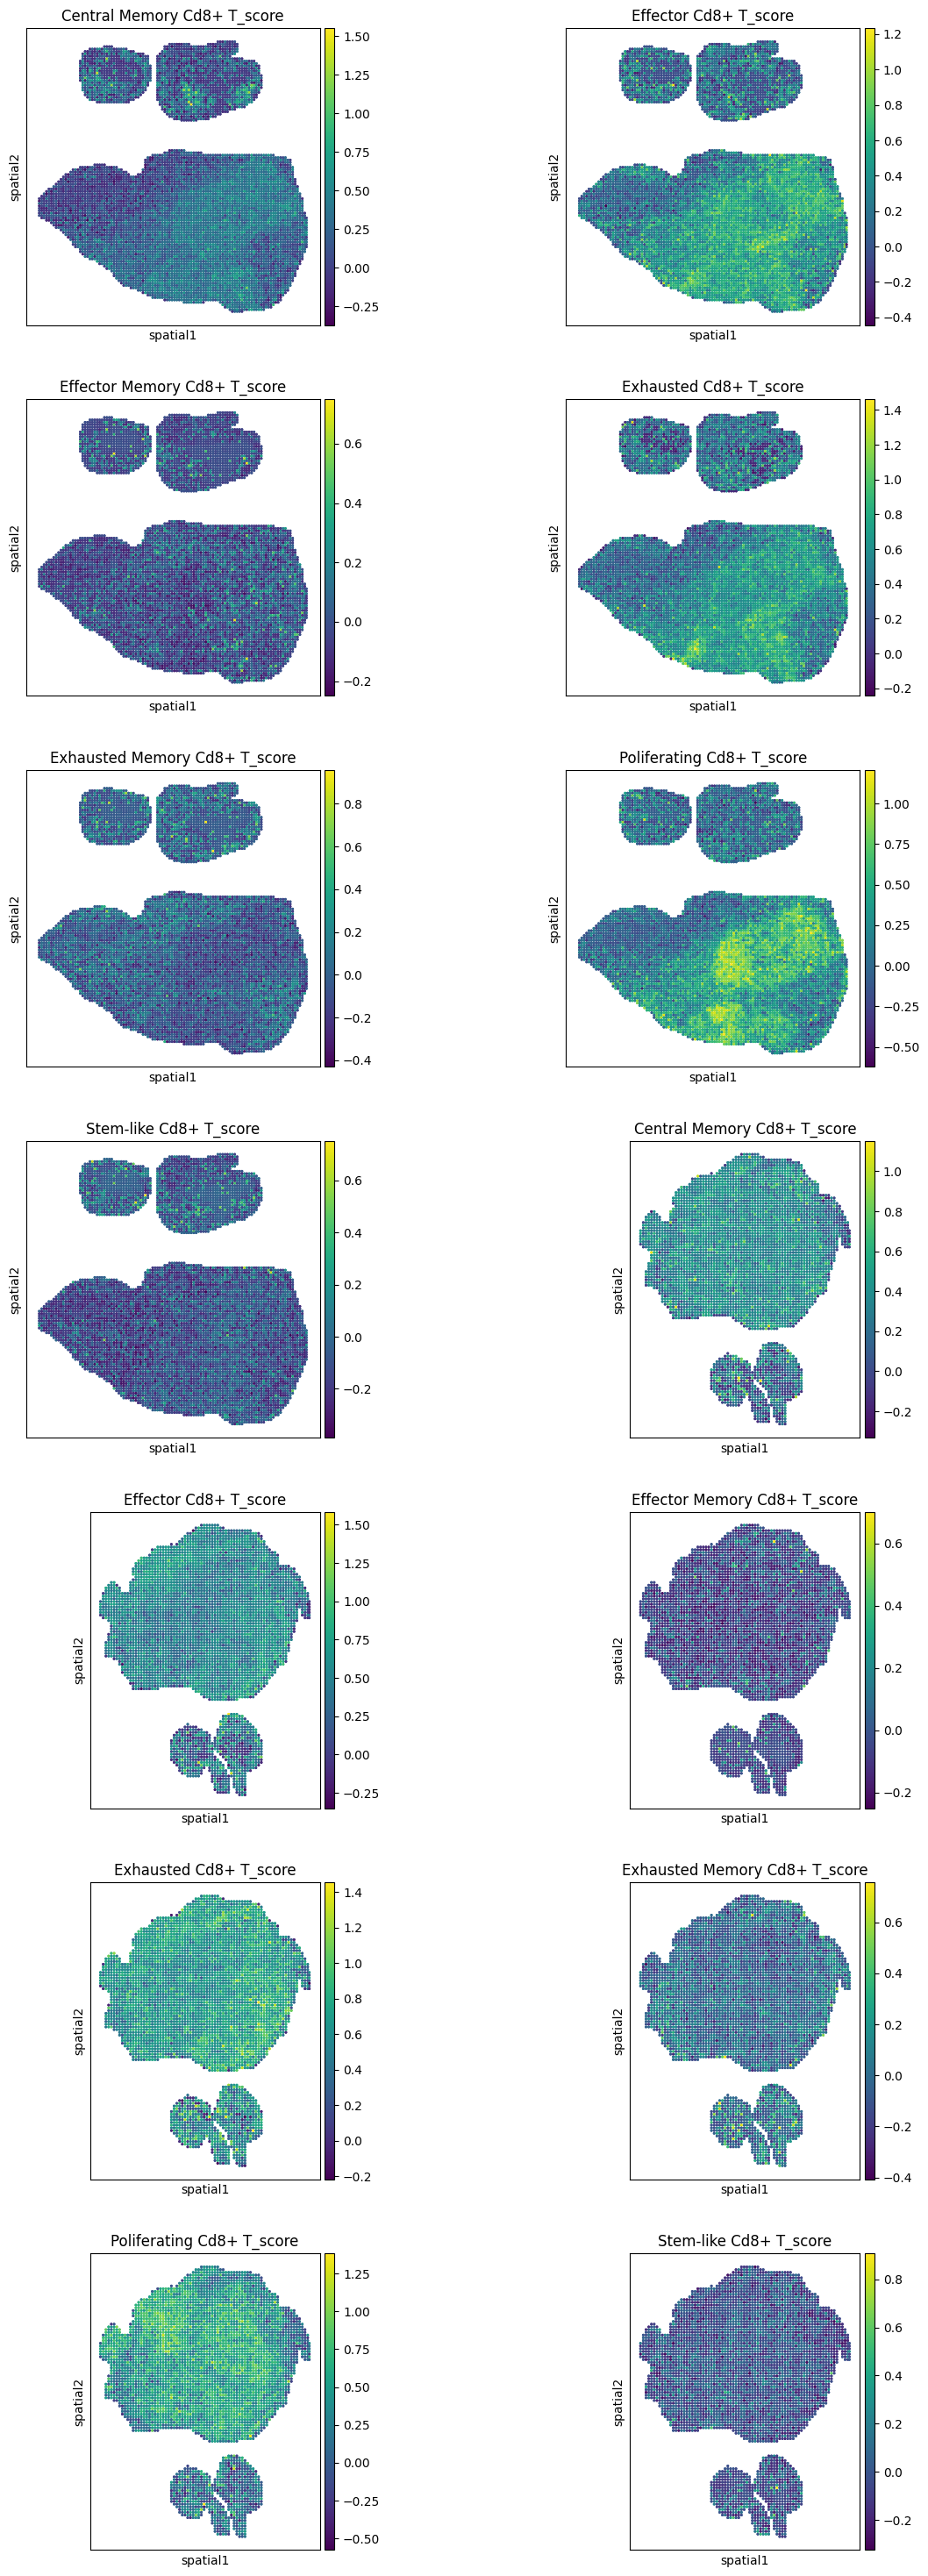

In [32]:
sq.pl.spatial_scatter(fdata,
    color=[t + '_score' for t in top_genes_df.Cluster.unique()],
    shape=None,
    size=5,
    library_key='marker',
    ncols=2)

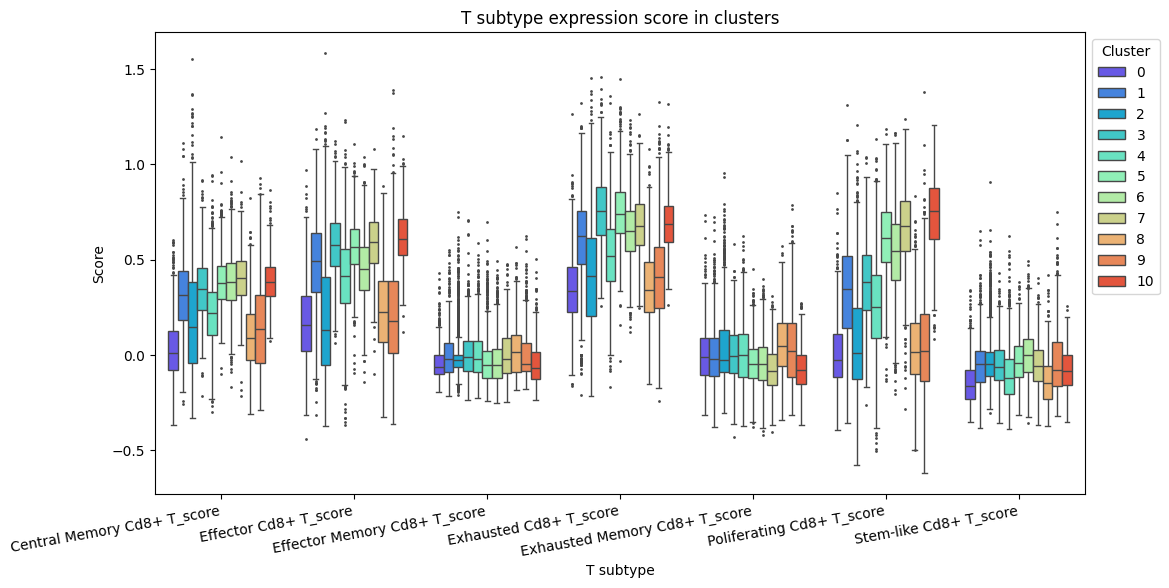

In [54]:
pdf = fdata.obs[['cluster'] + list(fdata.obs.columns[fdata.obs.columns.str.endswith('T_score')])].set_index('cluster').melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.boxplot(pdf, x='variable', hue='cluster', y='value', palette='rainbow', fliersize=1)
plt.ylabel('Score')
plt.xlabel('T subtype')
plt.xticks(rotation=10, ha='right')
plt.title('T subtype expression score in clusters')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))
plt.show()

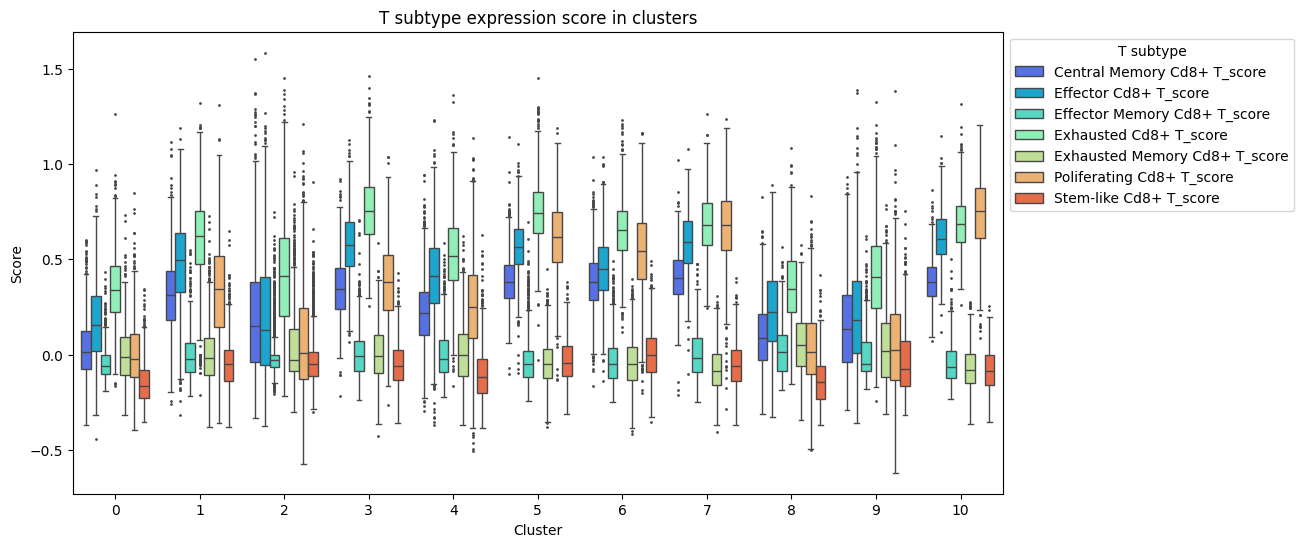

In [55]:
pdf = fdata.obs[['cluster'] + list(fdata.obs.columns[fdata.obs.columns.str.endswith('T_score')])].set_index('cluster').melt(ignore_index=False).reset_index()
plt.figure(figsize=(12, 6))
sns.boxplot(pdf, x='cluster', hue='variable', y='value', palette='rainbow', fliersize=1)
plt.ylabel('Score')
plt.xlabel('Cluster')
plt.title('T subtype expression score in clusters')
plt.legend(title='T subtype', bbox_to_anchor=(1, 1))
plt.show()

# Chemokine Receptor <-> Distribution

In [79]:
gsea_chemokine_rc = ["Ackr2", "Ackr3", "Ackr4", "Ccl1", "Ccl11", "Ccl12", "Ccl17", "Ccl19",
    "Ccl20", "Ccl21a", "Ccl21b", "Ccl21d", "Ccl21e", "Ccl21f", "Ccl22", "Ccl25", "Ccl27a", "Ccl27al",
    "Ccl27b", "Ccl28", "Ccl3", "Ccl4", "Ccl5", "Ccr10", "Ccr3", "Ccr4", "Ccr5", "Ccr6", "Ccr7", "Ccr8",
    "Ccr9", "Ccrl2", "Cx3cl1", "Cx3cr1", "Cxcl1", "Cxcl10", "Cxcl11", "Cxcl12", "Cxcl13", "Cxcl16",
    "Cxcl2", "Cxcl3", "Cxcl5", "Cxcl9", "Cxcr1", "Cxcr2", "Cxcr3", "Cxcr4", "Cxcr5", "Cxcr6",
    "Pf4", "Ppbp", "Xcl1", "Xcr1"]
gsea_chemokine_rc = np.array(gsea_chemokine_rc)[np.isin(gsea_chemokine_rc, fdata.var_names)]

In [110]:
from scipy.spatial import distance_matrix

In [428]:
def plot_lr_interaction(fdata, ligand, receptor, ax=None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    ax.set_facecolor('black')
    # sns.scatterplot(x=fdata_.obsm['spatial'][:, 0], y=fdata_.obsm['spatial'][:, 1],
    #     hue=fdata_.obs['cluster'], palette="Greys", ax=ax, alpha=0.05, legend=False)

    utils.plot_dot(fdata_, gene_name=ligand, ax=ax, color='White', square=False, alpha=1)
    utils.plot_dot(fdata_, gene_name=receptor, ax=ax, color='Aqua', square=False, alpha=1)

    lig_coords = fdata_[fdata_[:, ligand].X > 0].obsm['spatial']
    rec_coords = fdata_[fdata_[:, receptor].X > 0].obsm['spatial']
    dist_matrix = distance_matrix(lig_coords, rec_coords)

    inter_df = pd.DataFrame({
        'x': rec_coords[:, 0],
        'y': rec_coords[:, 1],
        'w': (dist_matrix < 250).sum(axis=0),
        'h': ['Interaction'] * rec_coords.shape[0]
    })

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.grid(True, color='gray')
    ax.set_title(f'{ligand} ~ {receptor} Interaction Strength')
    
    if inter_df.w.sum() == 0: return
    sns.kdeplot(inter_df, ax=ax, x='x', y='y', weights='w',
        fill=True, cmap='gnuplot2', bw_adjust=0.5, alpha=0.9)

    legend = ax.legend(loc='upper left', title='')
    legend.get_frame().set_facecolor('black')
    plt.setp(legend.get_texts(), color='white')

Object `fig.setp` not found.


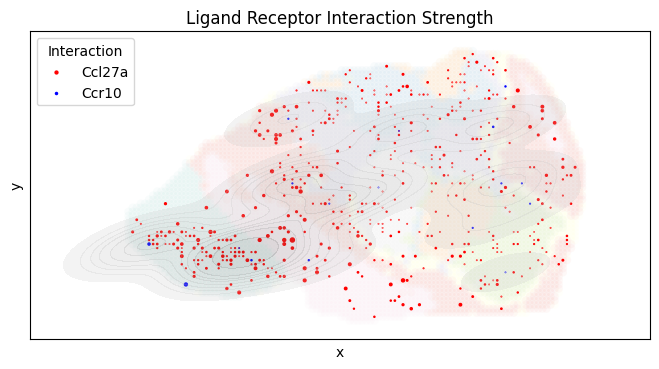

In [182]:
ligand, receptor = 'Ccl27a', 'Ccr10'
fdata_ = fdata[(fdata.obs.marker == 'A') & (fdata.obsm['spatial'][:, 1] > 4000)]

plot_lr_interaction(fdata_, 'Ccl27a', 'Ccr10')

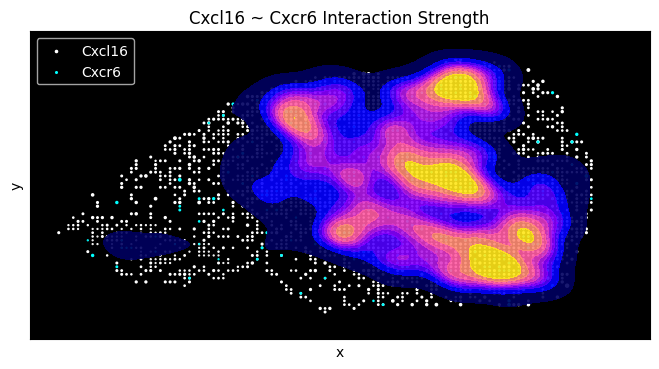

In [430]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
plot_lr_interaction(fdata_, 'Cxcl16', 'Cxcr6', ax=ax)

In [471]:
lr_pairs = [
    ('Ccr10', 'Ccl27a'), ('Ccr10', 'Ccl28'), ('Ccr6', 'Ccl20'), ('Ccr7', 'Ccl19'),
    ('Ccr9', 'Ccl19'), ('Ccr9', 'Ccl21a'), ('Ccr9', 'Ccl25'), ('Cx3cr1', 'Cx3cl1'),
    ('Cxcr2', 'Cxcl1'), ('Cxcr3', 'Cxcl9'), ('Ccrl2', 'Ccl19'),
    ('Cxcr2', 'Cxcl2'), ('Cxcr2', 'Cxcl3'), ('Cxcr2', 'Cxcl5'), ('Cxcr3', 'Cxcl9'), ('Cxcr3', 'Cxcl10'),
    ('Cxcr4', 'Cxcl12'), ('Cxcr5', 'Cxcl13'), ('Cxcr6', 'Cxcl16'), ('Ccr3', 'Ccl5'),
    ('Ccr4', 'Ccl5'), ('Ccr5', 'Ccl5'), ('Ackr2', 'Ccl1'), ('Ackr2', 'Ccl3'), ('Ackr2', 'Ccl4'),
    ('Ackr2', 'Ccl19'), ('Ackr2', 'Ccl20'), ('Ackr2', 'Ccl5'), ('Ackr2', 'Ccl25'),
    ('Ackr2', 'Ccl11'), ('Ackr2', 'Ccl12'), ('Ackr2', 'Ccl21a'), ('Ackr2', 'Ccl28'), ('Ackr2', 'Ccl27a'),
]
print(len(lr_pairs))

34


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scipy/stats/_kde.py:583: RuntimeWarning: Degrees of freedom <= 0 for slice
  self._data_covariance = atleast_2d(cov(self.dataset, rowvar=1,
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_46333/3713236688.py:31: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(inter_df, ax=ax, x='x', y='y', weights='w',


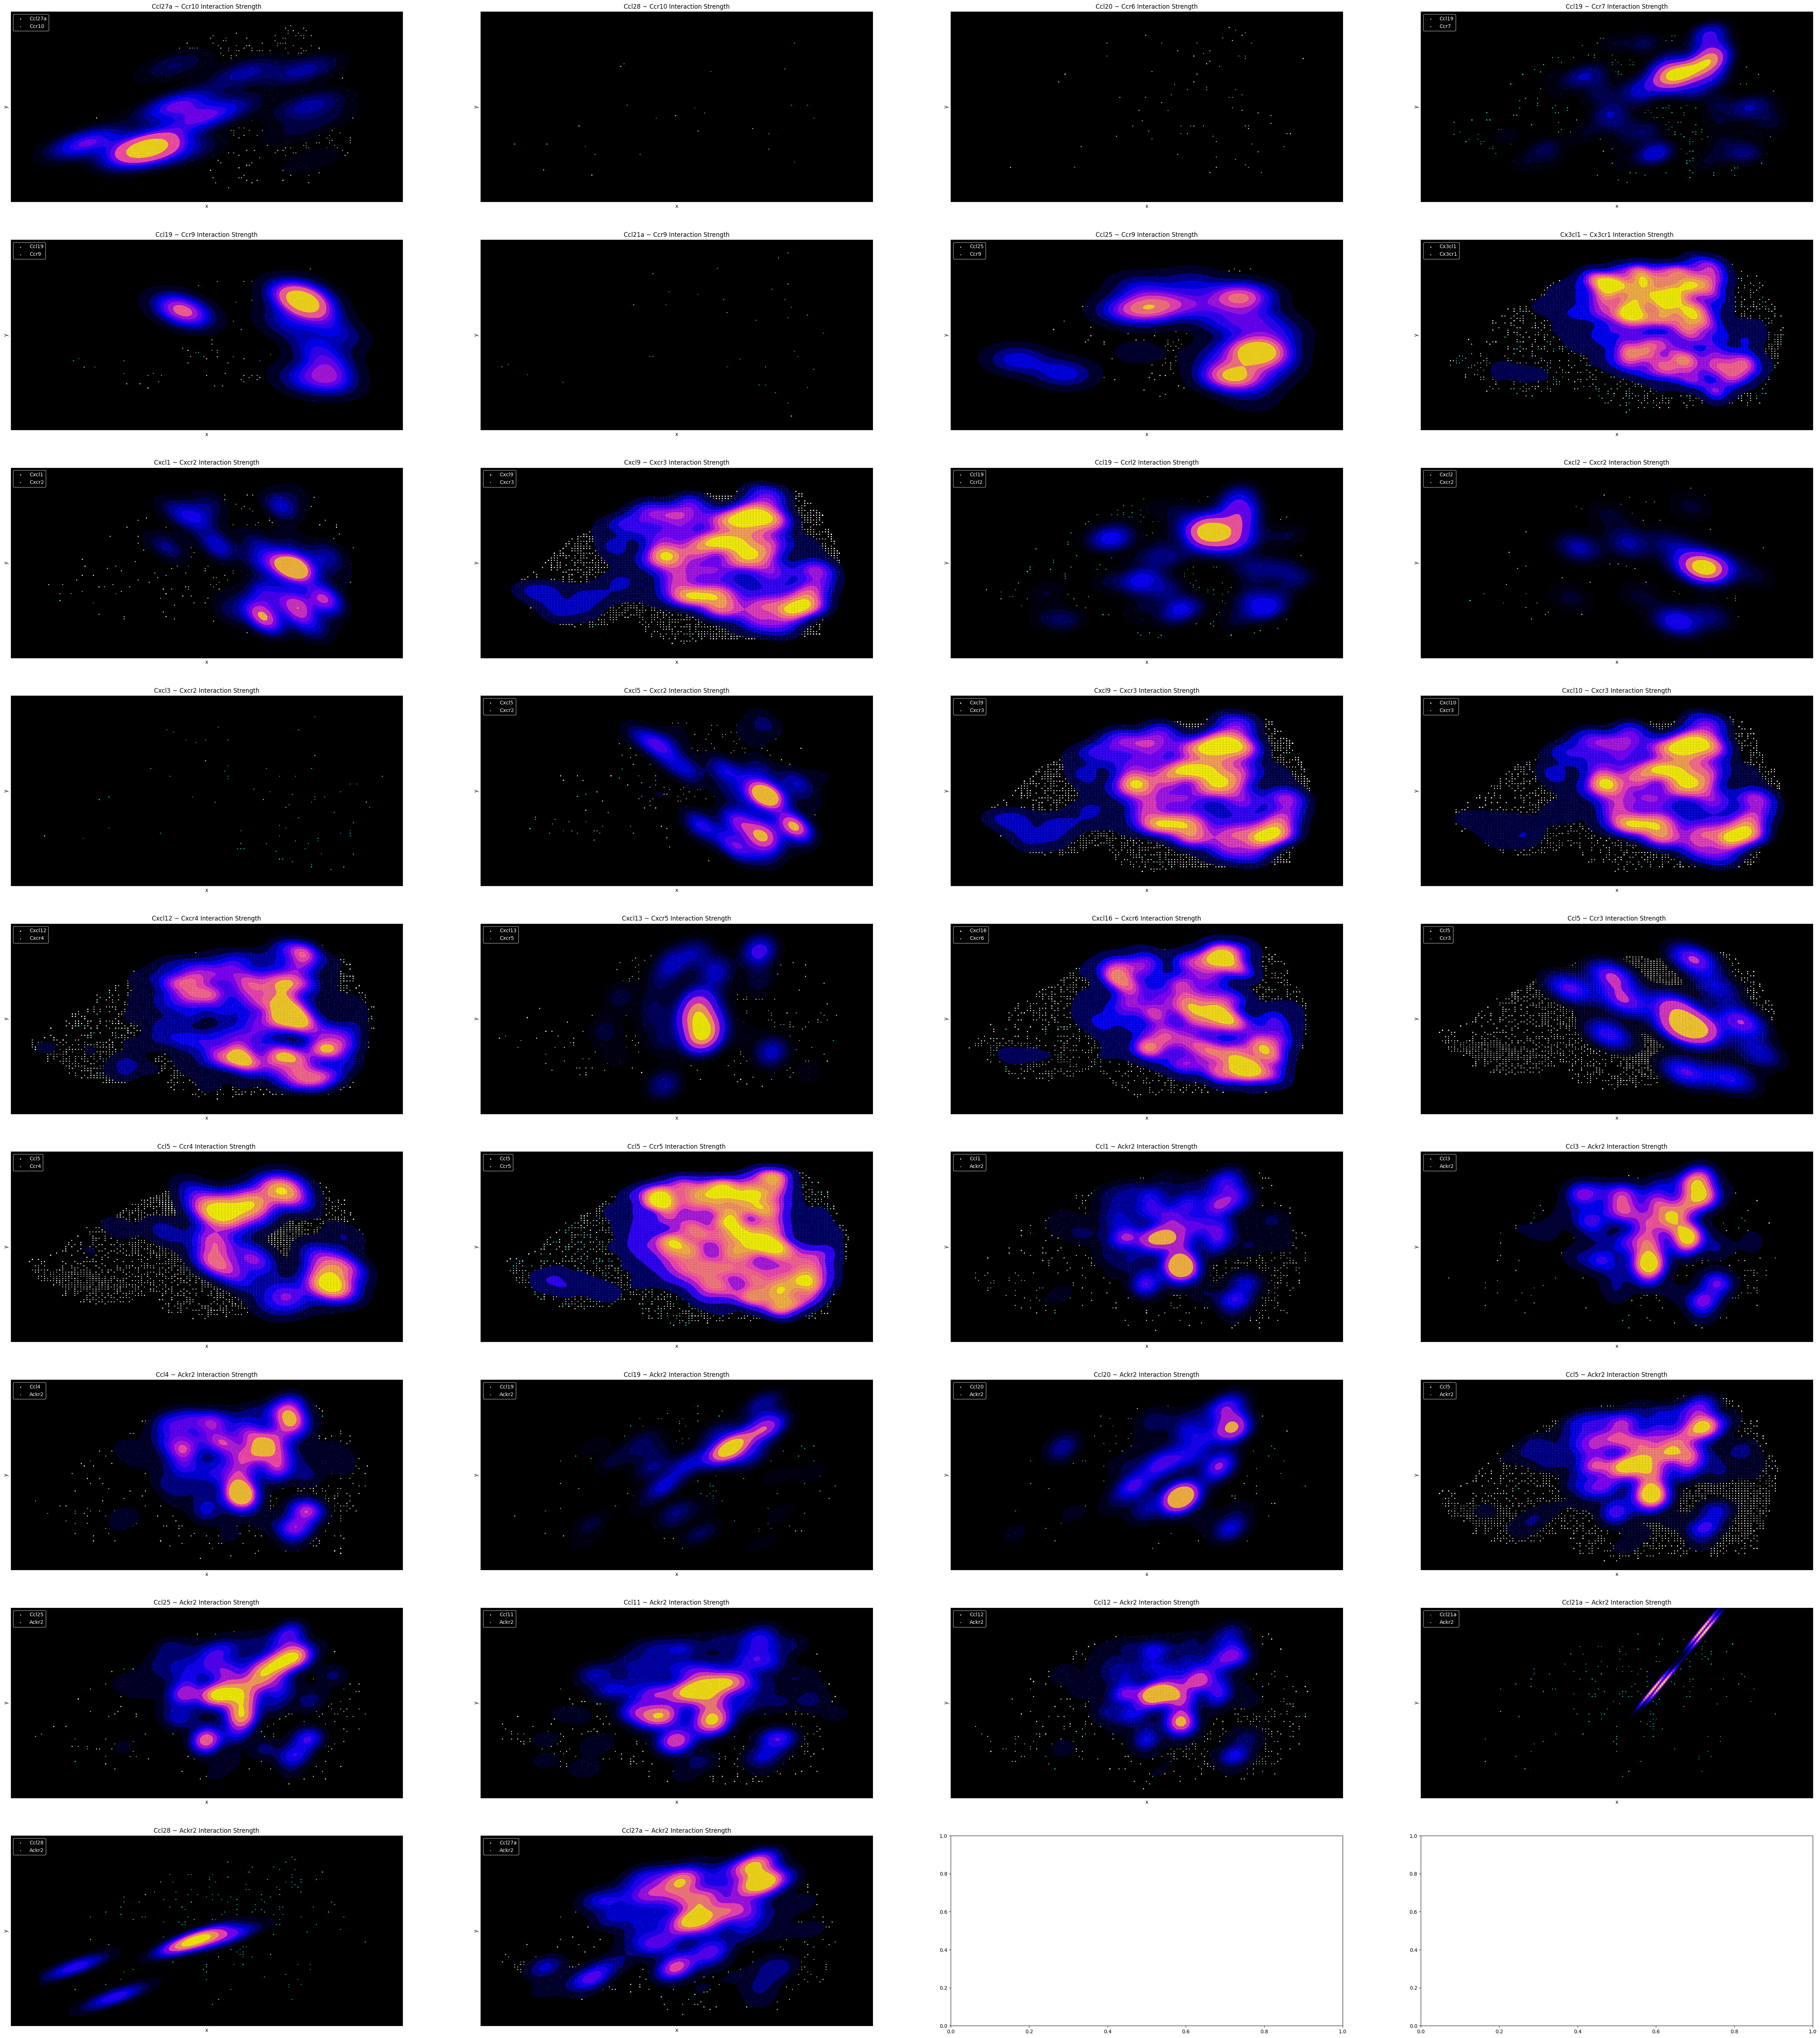

In [472]:
_, axs = plt.subplots(9, 4, figsize=(64, 72))
for idx, lr in enumerate(lr_pairs):
    ax = axs[idx // 4, idx % 4]
    try:
        plot_lr_interaction(fdata_, lr[1], lr[0], ax=ax)
    except:
        continue

In [193]:
sq.gr.spatial_neighbors(fdata_, coord_type='generic', library_key='marker', delaunay=False, set_diag=True, radius=250)
sq.gr.spatial_autocorr(fdata_, genes=gsea_chemokine_rc)

# Phenotype <-> Chemokine Receptor

In [236]:
import libpysal.weights.distance as lwd
from splot.esda import moran_scatterplot
from esda.moran import Moran_BV, Moran_Local_BV

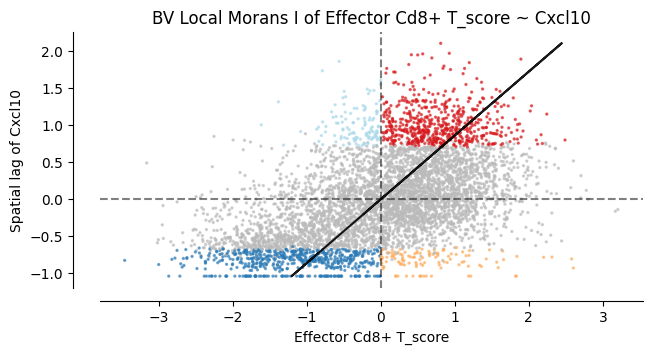

In [341]:
gene = 'Cxcl10'
score = 'Effector Cd8+ T_score'

y_matrix = fdata_[:, gene].X.toarray().flatten().tolist()
t_matrix = fdata_.obs[score]
w_matrix = lwd.DistanceBand.from_array(fdata_.obsm['spatial'], threshold=150)

moran_loc_bv = Moran_Local_BV(t_matrix, y_matrix, w_matrix)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.01, zstandard=True, scatter_kwds={'s': 2})
ax.set_title(f'BV Local Morans I of {score} ~ Cxcl10')
ax.set_xlabel(score)
ax.set_ylabel(f'Spatial lag of {gene}')
plt.show()

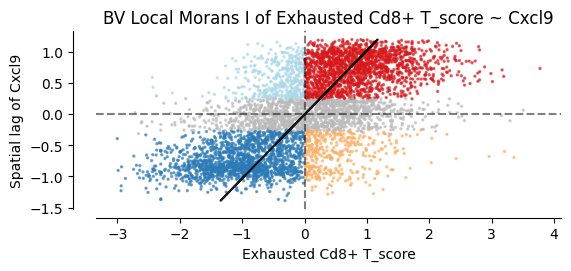

In [290]:
gene = 'Cxcl9'
score = 'Exhausted Cd8+ T_score'

y_matrix = fdata_[:, gene].X.toarray().flatten().tolist()
t_matrix = fdata_.obs[score]
w_matrix = lwd.DistanceBand.from_array(fdata_.obsm['spatial'], threshold=550)

moran_loc_bv = Moran_Local_BV(t_matrix, y_matrix, w_matrix)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.01, scatter_kwds={'s': 2})
fig.set_figwidth(6)
fig.set_figheight(6)
ax.set_title(f'BV Local Morans I of {score} ~ {gene}')
ax.set_xlabel(score)
ax.set_ylabel(f'Spatial lag of {gene}')
plt.show()

In [299]:
p_matrix = np.zeros([len(gsea_chemokine_rc), len(fdata_.obs.filter(regex='.*T_score').columns)])

from scipy.stats import spearmanr
for i, chem in enumerate(gsea_chemokine_rc):
    for j, score in enumerate(fdata_.obs.filter(regex='.*T_score').columns):
        p_matrix[i, j] = spearmanr(fdata_[:, chem].X.toarray().flatten().tolist(), fdata_.obs[score].tolist()).pvalue

In [301]:
rdf = pd.DataFrame(p_matrix, index=gsea_chemokine_rc, columns=fdata_.obs.filter(regex='.*T_score').columns)

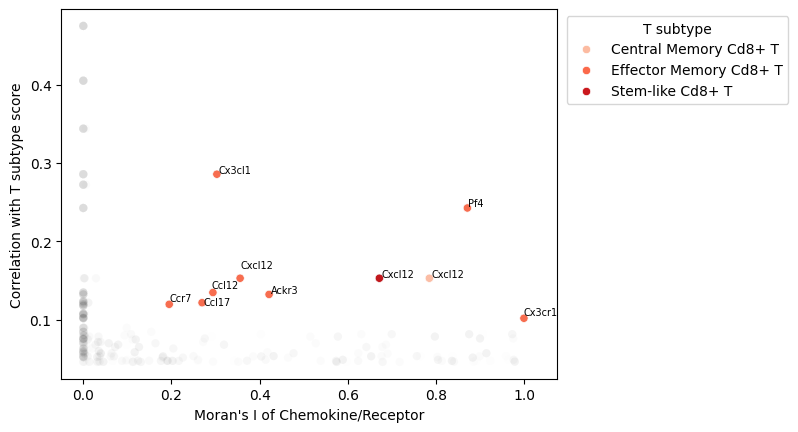

In [339]:
pdf = pd.DataFrame(columns=['moranI', 'score', 't_subtype'])
for score in rdf.columns:
    df = pd.concat([rdf[score], fdata_.uns['moranI']['I']], axis=1)
    df.columns = ['moranI', 'score']
    df['t_subtype'] = score.rstrip('_score')
    pdf = pd.concat([pdf, df])

sig_df = pdf[(pdf.moranI > 0.05) & (pdf.score > 0.1)]
ax = sns.scatterplot(sig_df, x='moranI', y='score', hue='t_subtype', palette='Reds')
sns.scatterplot(pdf, x='moranI', y='score', hue='t_subtype', ax=ax, alpha=0.05, palette='Greys', legend=False)

from adjustText import adjust_text
texts = []
for i, point in sig_df.iterrows():
    texts.append(plt.text(point['moranI'], point['score'], str(i), size=7))

adjust_text(texts, expand_axes=True)
plt.ylabel('Correlation with T subtype score')
plt.xlabel("Moran's I of Chemokine/Receptor")
plt.legend(title='T subtype', loc="upper right", bbox_to_anchor=(1.48, 1))
plt.show()